In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_predict, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.multioutput import MultiOutputClassifier

from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score

from xgboost import XGBClassifier

In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/train_test_data/train_encoded.csv")
test_df  = pd.read_csv("/content/drive/MyDrive/train_test_data/test_encoded.csv")

In [ ]:
TARGETS = ["Genetic Disorder", "Disorder Subclass"]

In [ ]:
X_train = train_df.drop(columns=TARGETS)
Y_train = train_df[TARGETS].copy()


In [ ]:
X_test  = test_df.copy()

In [ ]:
numeric_cols = X_train.select_dtypes(include=["int64","float64"]).columns.tolist()

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[("num", StandardScaler(), numeric_cols)],
    remainder="passthrough"
)

In [ ]:
base_xgb = XGBClassifier(
    n_estimators=800,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_alpha=0.0,
    reg_lambda=0.0,
    objective="multi:softprob",   # works for multiclass; XGB will auto-switch to binary if needed
    tree_method="hist",           # fast CPU histogram algorithm
    n_jobs=-1,
    random_state=42,
    eval_metric="mlogloss"
)

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
def evaluate_target(target_name: str):
    y = Y_train[target_name]
    pipe = Pipeline([("prep", preprocessor), ("clf", base_xgb)])

    # OOF predictions & probabilities
    y_pred_oof  = cross_val_predict(pipe, X_train, y, cv=cv, method="predict", n_jobs=-1)
    y_proba_oof = cross_val_predict(pipe, X_train, y, cv=cv, method="predict_proba", n_jobs=-1)

    # --- Text metrics
    print(f"\n=== {target_name} — OOF Classification Report (5-fold CV, XGBoost CPU) ===\n")
    print(classification_report(y, y_pred_oof, digits=4, zero_division=0))

    # --- Confusion Matrix (matplotlib only)
    classes = np.unique(np.concatenate([y.unique(), y_pred_oof]))
    cm = confusion_matrix(y, y_pred_oof, labels=classes)

    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(
        xticks=np.arange(len(classes)),
        yticks=np.arange(len(classes)),
        xticklabels=classes,
        yticklabels=classes,
        ylabel="True label",
        xlabel="Predicted label",
        title=f"Confusion Matrix — {target_name} (OOF, XGBoost)"
    )
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], "d"),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.show()

    # --- ROC (OvR) from OOF probabilities
    if y_proba_oof is not None and y_proba_oof.ndim == 2 and y_proba_oof.shape[1] >= 2:
        # Fit once to get class order (legend only)
        pipe.fit(X_train, y)
        cls_order = pipe.named_steps["clf"].classes_

        fig = plt.figure(figsize=(7, 5))
        for k, cls in enumerate(cls_order):
            fpr, tpr, _ = roc_curve((y == cls).astype(int), y_proba_oof[:, k])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, linewidth=2, label=f"{cls} (AUC={roc_auc:.2f})")
        plt.plot([0, 1], [0, 1], linestyle="--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curves (OvR) — {target_name} (OOF, XGBoost)")
        plt.legend()
        plt.show()


=== Genetic Disorder — OOF Classification Report (5-fold CV, XGBoost CPU) ===

              precision    recall  f1-score   support

           0     0.6375    0.7620    0.6942      9241
           1     0.4487    0.3031    0.3618      1877
           2     0.5335    0.4413    0.4831      6929

    accuracy                         0.5912     18047
   macro avg     0.5399    0.5022    0.5130     18047
weighted avg     0.5779    0.5912    0.5786     18047



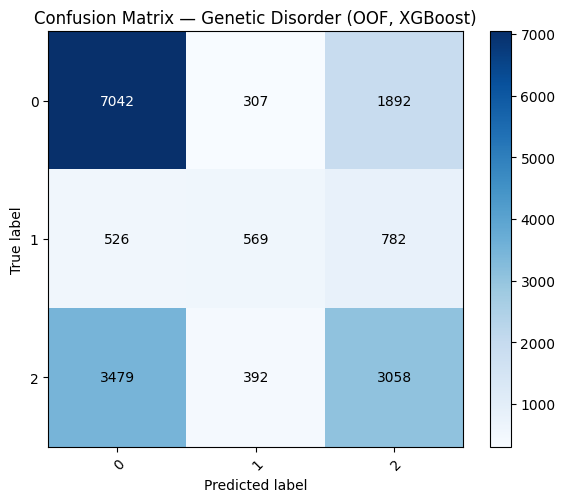

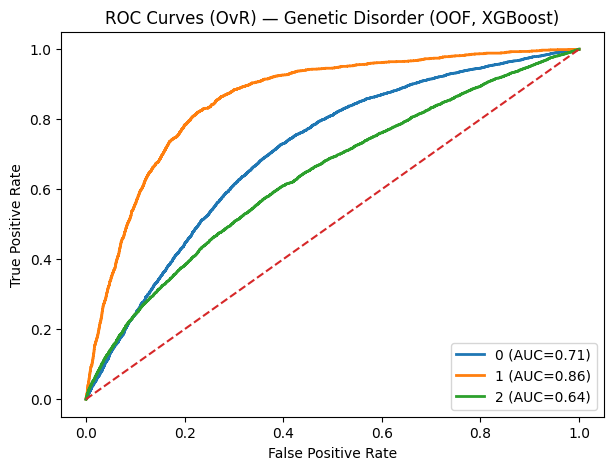


=== Disorder Subclass — OOF Classification Report (5-fold CV, XGBoost CPU) ===

              precision    recall  f1-score   support

           0     0.3158    0.0902    0.1404       133
           1     0.3182    0.0769    0.1239        91
           2     0.4463    0.4893    0.4669      3145
           3     0.3587    0.2535    0.2971      1653
           4     0.3758    0.2524    0.3020      1228
           5     0.3268    0.1414    0.1974       587
           6     0.4106    0.4950    0.4489      4683
           7     0.3470    0.3760    0.3609      3971
           8     0.3352    0.3075    0.3208      2556

    accuracy                         0.3860     18047
   macro avg     0.3594    0.2758    0.2953     18047
weighted avg     0.3812    0.3860    0.3785     18047



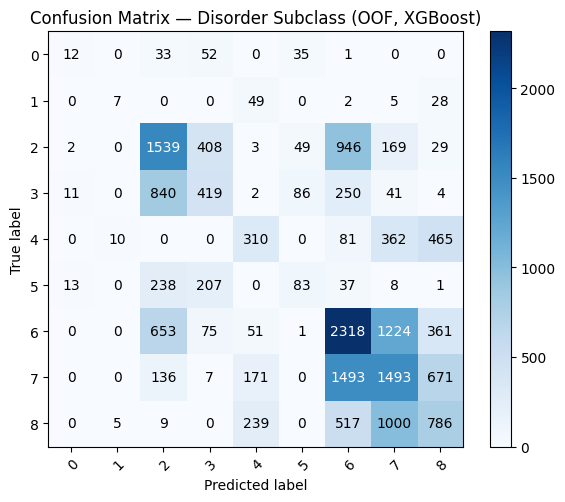

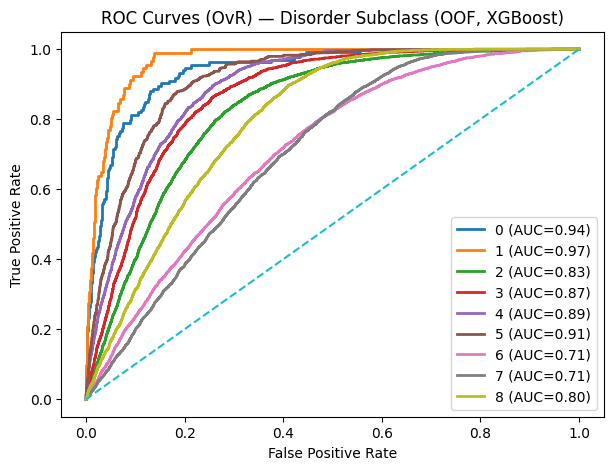

In [ ]:
for tgt in TARGETS:
    evaluate_target(tgt)


OOF summary per target (XGBoost):
           target  accuracy  balanced_accuracy  f1_macro  f1_weighted
 Genetic Disorder    0.5912             0.5022    0.5130       0.5786
Disorder Subclass    0.3860             0.2758    0.2953       0.3785

Overall mean accuracy (OOF across targets): 0.4886


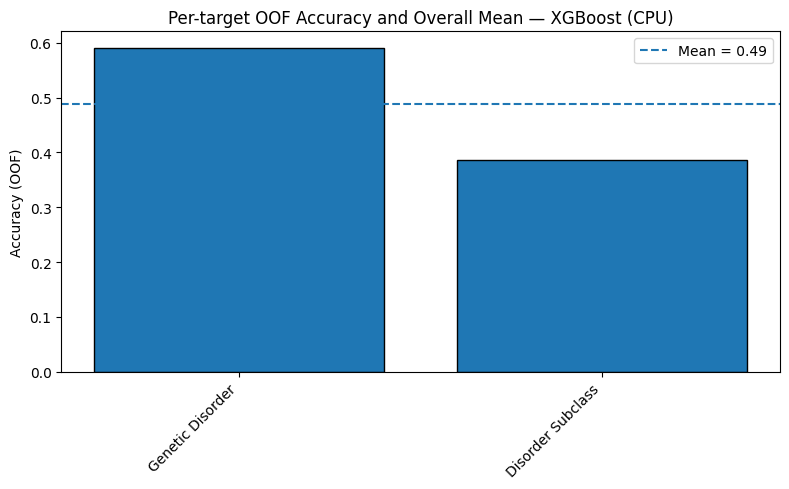

In [ ]:
per_target_rows = []
for tgt in TARGETS:
    y = Y_train[tgt]
    pipe = Pipeline([("prep", preprocessor), ("clf", base_xgb)])
    y_pred_oof = cross_val_predict(pipe, X_train, y, cv=cv, method="predict", n_jobs=-1)

    acc  = accuracy_score(y, y_pred_oof)
    bacc = balanced_accuracy_score(y, y_pred_oof)
    f1m  = f1_score(y, y_pred_oof, average="macro", zero_division=0)
    f1w  = f1_score(y, y_pred_oof, average="weighted", zero_division=0)
    per_target_rows.append({"target": tgt, "accuracy": acc, "balanced_accuracy": bacc, "f1_macro": f1m, "f1_weighted": f1w})

summary_df = pd.DataFrame(per_target_rows).round(4)
print("\nOOF summary per target (XGBoost):")
print(summary_df.to_string(index=False))

mean_acc = float(np.mean(summary_df["accuracy"]))
print("\nOverall mean accuracy (OOF across targets): {:.4f}".format(mean_acc))

plt.figure(figsize=(8,5))
plt.bar(summary_df["target"], summary_df["accuracy"], edgecolor="black")
plt.axhline(mean_acc, linestyle="--", label=f"Mean = {mean_acc:.2f}")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Accuracy (OOF)")
plt.title("Per-target OOF Accuracy and Overall Mean — XGBoost (CPU)")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
y_primary = Y_train["Genetic Disorder"]
pipe_gs = Pipeline([("prep", preprocessor), ("clf", XGBClassifier(
    objective="multi:softprob",
    tree_method="hist",
    n_jobs=-1,
    random_state=42,
    eval_metric="mlogloss"
))])

In [ ]:
param_grid = {
    "clf__n_estimators": [600, 800, 1000, 1200],
    "clf__max_depth": [4, 6, 8],
    "clf__learning_rate": [0.03, 0.05, 0.1],
    "clf__subsample": [0.7, 0.9, 1.0],
    "clf__colsample_bytree": [0.7, 0.9, 1.0],
    "clf__reg_alpha": [0.0, 0.1, 0.5],
    "clf__reg_lambda": [0.0, 0.1, 0.5],
}

In [ ]:
gs = GridSearchCV(
    estimator=pipe_gs,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1,
    verbose=0
)

In [ ]:
gs.fit(X_train, y_primary)

print("\nBest params (Genetic Disorder, macro-F1, XGBoost):", gs.best_params_)
print("Best CV macro-F1:", round(gs.best_score_, 4))